<a href="https://colab.research.google.com/github/BenUCL/Reef-acoustics-and-AI/blob/main/Tutorial/3-Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning with coral reef soundscape data**

This notebook is a supporting tutorial for the study **Unlocking the soundscape of coral reefs with artificial intelligence** by [Williams et al (2024a)](https://www.biorxiv.org/content/10.1101/2024.02.02.578582v1). If you use any of these methods after reading this then please cite the article.

In this publication we recommend combining pretrained neural networks with unsupervised learning for analysing soundscape ecology.

What this notebook does:
1. Use UMAP to explore data qualitatively.
2. Use UMAP to reduce dimensions of data and then train an unsupervised clustering algorithm to explore data quantitatively.

# **Step 1: Set up**

## Import dependencies

UMAP is used for dimensionality reduction, but the `umap-learn` package isn't included by default in Colab. 
Therefore, we begin by installing it. 
If you're running this notebook locally and have `umap-learn` installed, you can skip the installation cell.

In [ ]:
# Install UMAP
%pip install umap-learn

In [ ]:
# Import packages
import os # for handling files and directories
import librosa # for audio processing
import tensorflow as tf # for machine learning
import tensorflow_hub as hub # for machine learning
import numpy as np # for numerical processing
import pandas as pd # for handling dataframes
from tqdm import tqdm # for progress bar
import matplotlib.pyplot as plt # for potting
from sklearn.cluster import KMeans # for clustering
import umap

# To get reproducible results, we set the seed
random_seed = 0

## Load the extracted features dataframe

In this notebook you will need the CSV file containing the extracted features, generated by the `2-Feature_Extraction.ipynb` notebook.
If you are using Google Colab, upload the file or mount your Google Drive if it is stored there. 
If you are running this notebook locally, make sure the file path below is correct or adjust it if necessary.

In [ ]:
#@title Set filepaths

# Directory for all analysis outputs, including the extracted feature CSV from the feature extraction notebook.
OUTPUT_DIR = "outputs"

# Path where the csv of extracted features was saved
features_df_path = os.path.join(OUTPUT_DIR, 'surfperch_feature_embeddings.csv')

# Path where we will save an updated version of features_df, with added metadata
features_metadata_path = os.path.join(OUTPUT_DIR, 'updated_surfperch_feature_embeddings.csv')

# Path where we will save cluster results
cluster_results_path = os.path.join(OUTPUT_DIR, 'cluster_results.csv')

## Take a peek at the features dataframe

Check it looks in order. Note each file was split into 5s samples, so we have the added 'embedding_index' column which denotes which sample of a longer file this row pertains to, e.g for a 60s file there will be 12 rows.

In [4]:
# Load the saved csv as a dataframe
features_df = pd.read_csv(features_df_path)

features_df

,filename,embedding_index,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_1270,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279
0,D.SaF3.1355.805322778.180829.1.5.wav,1,0.095266,-0.043760,-0.186835,-0.065721,-0.135039,0.027893,0.030612,0.336429,...,0.009653,-0.008715,-0.053117,-0.002967,-0.015146,-0.008182,0.339541,0.042919,0.064481,0.010667
1,D.SaF3.1355.805322778.180829.1.5.wav,2,-0.054386,-0.070658,-0.062030,-0.026162,-0.055553,0.048730,0.084917,0.261091,...,0.033196,-0.021291,-0.043879,0.017621,-0.015038,0.005198,-0.079819,0.041414,0.061947,0.017771
2,D.SaF3.1355.805322778.180829.1.5.wav,3,-0.013306,-0.028767,-0.042732,0.045478,-0.086306,0.041371,0.079206,0.216338,...,0.050451,0.016551,-0.128548,0.028641,-0.015715,0.001647,-0.069922,0.030726,0.002214,0.012486
3,D.SaF3.1355.805322778.180829.1.5.wav,4,0.128021,-0.055525,0.031539,-0.026539,-0.077078,0.055511,0.033902,0.314529,...,0.015063,0.009737,-0.015940,0.034475,-0.019154,0.023457,0.255913,0.038950,0.007818,0.011662
4,D.SaF3.1355.805322778.180829.1.5.wav,5,0.035347,-0.069571,-0.005956,-0.024740,-0.112405,0.024988,0.090412,0.186201,...,0.039776,0.023733,0.054703,0.050067,-0.005310,0.010681,-0.042922,0.042997,0.055794,0.012468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,H.BaF3.0915.1678278701.180829.2.30.wav,8,0.052924,-0.028343,-0.041132,-0.069430,-0.073702,0.088496,-0.091703,-0.036165,...,-0.006155,-0.065905,-0.150666,0.093934,-0.009525,0.030543,-0.086864,0.045006,0.010965,0.037594
3140,H.BaF3.0915.1678278701.180829.2.30.wav,9,-0.059150,-0.055043,-0.055807,0.073265,-0.052938,0.115610,0.009453,0.115414,...,0.041878,-0.031102,-0.159292,-0.062542,-0.017308,0.012166,-0.128742,0.028227,-0.013661,0.013006
3141,H.BaF3.0915.1678278701.180829.2.30.wav,10,-0.029610,-0.038658,-0.108122,-0.061626,0.116923,0.025992,0.068813,0.105473,...,-0.005419,-0.067728,-0.186287,0.004383,-0.026162,0.011837,-0.088420,0.026192,0.010454,-0.012032
3142,H.BaF3.0915.1678278701.180829.2.30.wav,11,-0.042929,-0.036163,-0.095022,-0.037912,-0.041864,0.154841,-0.023873,0.189126,...,0.013159,-0.125300,-0.210276,0.023335,-0.007543,0.031137,0.002488,0.033958,-0.011404,0.001926


## Add further metadata to df

For now we will just add the class of site that the audio came from. This is healthy, degraded or restored.

In the sample data you can see each filename starts with an H, D or R corresponding to these classes. For your own data, you may wish to change these or add further meta data to the filename to be explored during analysis. You can save this in your filename (or use a separate file to link filenames to classes) and then modify the cells below accordingly.

In [ ]:
def extract_metadata_from_filename(filename):
    # Add more metadata to the cell (separated by '.') and add more code here accordingly.
    parts = filename.split('.')
    class_type = parts[0]
    return class_type

# Applying the function to each filename in the DataFrame
features_df[['class_type']] = features_df['filename'].apply(
    lambda x: pd.Series(extract_metadata_from_filename(x))
)

# Arrange columns in desired order
column_order = ['filename', 'embedding_index', 'class_type'] + \
               [col for col in features_df.columns if col.startswith('feature_')]
features_metadata_df = features_df[column_order]

# Save df
features_metadata_df.to_csv(features_metadata_path, index = False)

# Take a look
features_metadata_df

# **Step 2: UMAP visualisation**

Run UMAP to visualise the data. This compresses the features down to 2 dimensions so we can see a plot which produces groupings of similar sounding recordings.

For new data, you can try adjusting the n_neighbors and min_dist parameters and until you find a plot with a distribution of points that is most easily interpretable, e.g no huge or tiny gaps between clusters and points not all one ontop of each other or highly spread out.

In [ ]:
#@title Generate Standard UMAP plots
n_neighbors = 5 # adjust for new data
min_dist = 0.8 # adjust for new data

# Set the seed for reproducibility
reducer = umap.UMAP(random_state=random_seed, n_neighbors=n_neighbors, min_dist=min_dist)

# Perform the dimensionality reduction (assuming features start from the 4th column)
umap_embeddings = reducer.fit_transform(features_metadata_df.iloc[:, 3:]) # Make sure the integer is the first feature column (count up from 0)!

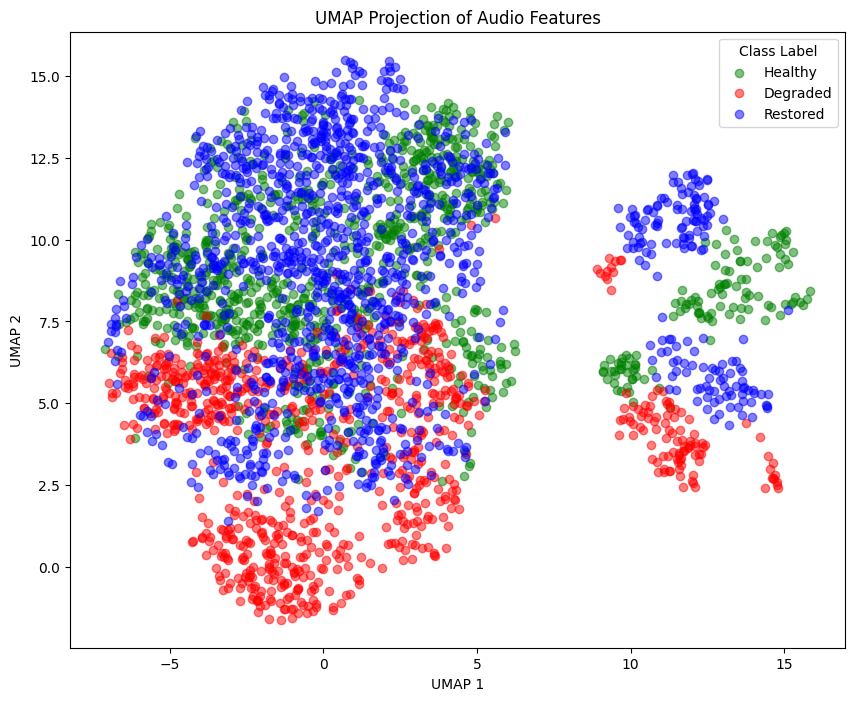

In [7]:
# Mapping from single letters to words for descriptive labels
class_mapping = {'H': 'Healthy', 'D': 'Degraded', 'R': 'Restored'}
color_mapping = {'Healthy': 'green', 'Degraded': 'red', 'Restored': 'blue'}

# Set up the plot
plt.figure(figsize=(10, 8))

# Plot each class with its own color and label using the mapping
for class_type, label in class_mapping.items():
    # Select only data rows with the current class_type, mapping them to descriptive labels on-the-fly
    indices = features_metadata_df['class_type'] == class_type
    plt.scatter(umap_embeddings[indices, 0], umap_embeddings[indices, 1], label=label,
                color=color_mapping[label], alpha=0.5)  # Assigning specific colors

plt.title('UMAP Projection of Audio Features')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Class Label')  # Adds a legend with a title
plt.show()

## What are we seeing?

The UMAP plot shows us a few key things:
1. Each point represents a 5s audio clip. The first thing we're seeing is that soundscape data is noisy, there's a lot of overlap!
2. However, if you look more closely you can see most healthy and degraded recordings clearly diverge from one another.
3. Looking at the restored data, we can see most of these overlap the space occupied by the healthy recordings
4. There is also a clear outgroup to the right. This is likely from a different temporal period, individual recorder or other confounding variable. Its always important to consider how these may influence the results and control for these (i.e record across the same temporal periods on each site, calibrate recorders etc).

# **Step 3: Clustering**

Now we are going to perform unsupervised clustering on our dimension reduced data. We'll start with k-means clustering.

SurfPerch outputs feature embeddings that are 1280 dimensions long. This is quite a lot of features to put into simple classification or clustering algorithms. Dimensionality reduction can help compress these, reducing noise and merging correlated features. We're going to reduce the dimensions by a factor of 40, down to 32. We will use UMAP to do this once again.

Then we will perform clustering using the dim reduced embeddings.

In [ ]:
#@title Dimensionality reduction with UMAP

# Number of dimensions to be output by UMAP
n_dims = 32

# n_neighbors and min_dist are important parameters, but we can use common defaults
reducer = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist, random_state = random_seed, n_components = n_dims)

# Perform the dimensionality reduction (assuming features start from the 4th column)
umap_embedding = reducer.fit_transform(features_metadata_df.iloc[:, 3:])

In [ ]:
# Copy the original DataFrame to preserve the original data
cluster_results = features_metadata_df.copy()

# Set variables
num_clusters = 10

# Apply k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=random_seed)
clusters = kmeans.fit_predict(umap_embeddings)

# Add the cluster information to the new DataFrame
if 'cluster' in cluster_results.columns:
    cluster_results['cluster'] = clusters
else:
    cluster_results.insert(2, 'cluster', clusters)

# Save and view the results
cluster_results.to_csv(cluster_results_path, index=False)
cluster_results

## View results

The `cluster_results` has now been saved to the results folder in your GDrive. We will now visualise the clustering results.

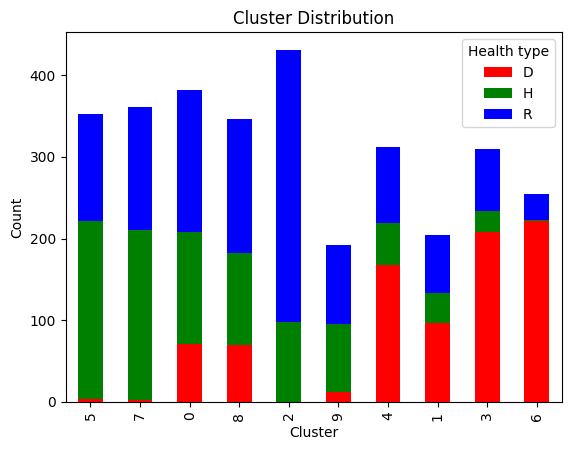

In [10]:
# Group by 'cluster' and 'class_type', and count occurrences
cluster_class_counts = cluster_results.groupby(['cluster', 'class_type']).size().unstack().fillna(0)

# Sort clusters by the count of 'H' in descending order
if 'H' in cluster_class_counts.columns:
    cluster_class_counts = cluster_class_counts.sort_values(by='H', ascending=False)

# Create the bar plot
cluster_class_counts.plot(kind='bar', stacked=True, color=['red', 'green', 'blue'])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.legend(title='Health type')
plt.show()

## What are we seeing?

The cluster results were saved to a table `cluster_results` and we've plotted the makeup of each cluster. The clusters are ordered from having the most to least healthy recordings.

We can see a few key things:
1. Healthy and degraded reefs clearly diverge from one another in terms of cluster assignment. This would likely be highly statistically significant if tested.
2. The restored recordings were mostly assigned to clusters with higher ratios of healthy recordings. Once again a statistical test on the table could be used to confirm this.

# **Conclusions**

The two notebooks presented here for 'Feature Extraction' and 'Unsupervised Learning' present a foundation to be adapted for new soundscape work using an example dataset.

You can now try this on your own data. You can modify this code or try and stick to its current form by mimicking the folder structure and naming format of our data. The feature extraction should run smoothly if this is done. Unsupervised analysis may require further modification for your use case if it differs significantly.